In [1]:
import numpy as np
from numpy import *
import matplotlib.pyplot as plt
import cv2
import pandas as pd
from scipy import ndimage

In [2]:
#cargar mascaras de entrenamiento para hallar el tamanho del poligono
path='./BD2/conjunto de datos/entrenamiento_generado.txt'
def leer_conjunto_entrenamiento(path):
    with open(path) as f:
        contents = f.readlines()
    array_data_mask = []
    for i in range(len(contents)):
        m=contents[i].replace('\n','')
        array_data_mask.append(m)
    return array_data_mask

data_entrenar = leer_conjunto_entrenamiento(path)

In [3]:
data_entrenar = leer_conjunto_entrenamiento(path)

In [4]:
#transformar imagenes a binario
def image_binarize(path_image):
    imagen=cv2.imread(path_image)
    imagen_grayscale=cv2.cvtColor(imagen,cv2.COLOR_BGR2GRAY)
    (thresh, imagen_binary) = cv2.threshold(imagen_grayscale, 50, 1, cv2.THRESH_BINARY)
    return imagen_binary

In [5]:
#encontrar las coordenadas maximas y minimas de las posiciones de las mascaras
def get_coordinates(image):
    x_max= -np.inf
    x_min= +np.inf
    y_max= -np.inf
    y_min= +np.inf
    a=0
    for x in range(np.shape(image)[0]):
        for y in range(np.shape(image)[1]):
            a=image[x,y]
            if a==1:
                if x>x_max:
                    x_max=x
                if x<x_min:
                    x_min=x
                if y>y_max:
                    y_max=y
                if y<y_min:
                    y_min=y
    return [x_min,x_max,y_min,y_max]

In [6]:
#encontrar los centros de las mascaras para entrenamiento
def dict_encontrar_centros_mascaras(data_entrenar):
    dict_image_mask_coord={}
    for i in data_entrenar:
        ii=i.replace('mask','orig')
        dict_image_mask_coord[ii]=get_coordinates(image_binarize(i))
    return dict_image_mask_coord

#encontrar en ancho y largo de los rectangulos que contienen las mascaras
def dict_encontrar_W_H(data_entrenar):
    dict_image_W_H={}
    dict_image_mask_coord=dict_encontrar_centros_mascaras(data_entrenar)
    for i in data_entrenar:
        ii=i.replace('mask','orig')
        dict_image_W_H[ii]=[dict_image_mask_coord[ii][1]-dict_image_mask_coord[ii][0],dict_image_mask_coord[ii][3]-dict_image_mask_coord[ii][2]]
    return dict_image_W_H

#encontrar dimesiones maximas de los rectangulos que contienen las mascaras
def array_W_H_maximos_mascaras(data_entrenar):
    W_max=0
    H_max=0
    dict_image_W_H=dict_encontrar_W_H(data_entrenar)
    for i in data_entrenar:
        ii=i.replace('mask','orig')
        if dict_image_W_H[ii][0]>W_max:
            W_max=dict_image_W_H[ii][0]
        if dict_image_W_H[ii][1]>H_max:
            H_max=dict_image_W_H[ii][1]
    return [W_max,H_max]

#encontrar centro de los rectangulos que contienen las mascaras
def dict_encontrar_centro_rectangulo_mask(data_entrenar):
    dict_image_centro_mask_orig={}
    dict_image_mask_coord=dict_encontrar_centros_mascaras(data_entrenar)
    dict_image_W_H=dict_encontrar_W_H(data_entrenar)
    for i in data_entrenar:
        ii=i.replace('mask','orig')
        dict_image_centro_mask_orig[ii]=[dict_image_mask_coord[ii][0]+int(dict_image_W_H[ii][0]/2),dict_image_mask_coord[ii][2]+int(dict_image_W_H[ii][1]/2)]
    return dict_image_centro_mask_orig

In [7]:
dict_image_centro_mask_orig=dict_encontrar_centro_rectangulo_mask(data_entrenar)

In [8]:
array_W_H_max=array_W_H_maximos_mascaras(data_entrenar)
array_W_H_max

[52, 113]

In [9]:
#array de centros de rectangulos standar
def array_encontrar_centros_standar(W_fijo=60,H_fijo=112,dx=12,dy=16):
    dict_array_centros={}
    array_centros=[]
    for k in range(15):
        x_i = W_fijo/2 + k*dx
        for l in range(15):
            y_i = H_fijo/2 + l*dy
            A = [int(x_i),int(y_i)]
            array_centros.append(A)
    return array_centros

#diccionario de centros de rectangulos standar 
def dict_encontrar_centros_standar(W_fijo=60,H_fijo=112,dx=12,dy=16):
    dict_array_centros={}
    array_centros=array_encontrar_centros_standar(W_fijo,H_fijo,dx,dy)
    for i in range(np.shape(array_centros)[0]):
        dict_array_centros[i]=array_centros[i]
    return dict_array_centros 

In [10]:
array_centros=array_encontrar_centros_standar(W_fijo=60,H_fijo=112,dx=12,dy=16)
dict_array_centros=dict_encontrar_centros_standar()

In [11]:
#mapa de bits de imagen nueva generada a partir del tamanho de las subimagenes
def generar_sub_image(path_image,centro,W_fijo=60,H_fijo=112):
    imagen_prueba=image_binarize(path_image)
    imagen_nueva=[]
    bit_imagen=imagen_prueba[centro[0]][centro[1]]
    for x in range(int(-W_fijo/2),int(W_fijo/2)):
        bit_imagen=imagen_prueba[centro[0]+x,centro[1]]
        imagen_nueva_columna=[]
        for y in range(int(-H_fijo/2),int(H_fijo/2)):
            bit_imagen=imagen_prueba[centro[0]+x,centro[1]+y]
            imagen_nueva_columna.append(bit_imagen)
        imagen_nueva.append(imagen_nueva_columna)
    return imagen_nueva

#diccionario de 225 subimagenes generadas por imagen a partir del array de centros
def dict_generar_sub_imagenes(path_image,array_centros,W_fijo=60,H_fijo=112):
    dict_sub_imagenes_total={}
    for i in range(np.shape(array_centros)[0]):
        dict_sub_imagenes_total[i]=generar_sub_image(path_image,array_centros[i],W_fijo,H_fijo)
    return dict_sub_imagenes_total

In [12]:
#leer los archivos del conjunto de entranamiento original
path_1='./BD2/conjunto de datos/entrenamiento1.txt'
data_entrenar_orig=leer_conjunto_entrenamiento(path_1)

In [13]:
def dict_todos_dict_generar_sub_imagenes(data_entrenar_orig,array_centros,W_fijo=60,H_fijo=112):
    dict_sub_images_total_todos={}
    for j in range(np.shape(data_entrenar_orig)[0]):
        dict_sub_images_total_todos[j]={}
        for i in range(np.shape(array_centros)[0]): 
            dict_sub_images_total_todos[j][i]=generar_sub_image(data_entrenar_orig[j],array_centros[i],W_fijo,H_fijo)
    return dict_sub_images_total_todos

In [14]:
dict_sub_images_total_todos=dict_todos_dict_generar_sub_imagenes(data_entrenar_orig,array_centros,W_fijo=60,H_fijo=112)

In [15]:
#encontrar centros 9 cercanos a las mascaras de las placas que seran etiquetados como placas para el entraamiento
def array_encontrar_coordenada_placas(path,dict_array_centros,dx=12,dy=16):
    dif_x_centro=+np.inf
    dif_y_centro=+np.inf
    centro_mask=dict_image_centro_mask_orig[path]

    for i in range(len(dict_array_centros.keys())):

        dif_x=abs(centro_mask[0]-dict_array_centros[i][0])
        dif_y=abs(centro_mask[1]-dict_array_centros[i][1])

        if dif_x < dif_x_centro:
            dif_x_centro=dif_x
            x_centro=dict_array_centros[i][0]

        if dif_y < dif_y_centro:
            dif_y_centro=dif_y
            y_centro=dict_array_centros[i][1]
            
    x_centro
    y_centro
    coordenadas_placas=[
    [x_centro-dx,y_centro-dy],
    [x_centro-dx,y_centro],
    [x_centro-dx,y_centro+dy],

    [x_centro,y_centro-dy],
    [x_centro,y_centro],
    [x_centro,y_centro+dy],

    [x_centro+dx,y_centro-dy],
    [x_centro+dx,y_centro],
    [x_centro+dx,y_centro+dy]
    ]
    
    return coordenadas_placas

#generar diccionario de las coordenadas de los centros de las imaganes que son placas
def dict_encontrar_coordenada_placas(path,data_entrenar_orig,dict_array_centros,dx=12,dy=16):
    dict_coordenadas_placas_imagenes={}
    for i in data_entrenar_orig:
        dict_coordenadas_placas_imagenes[i]=array_encontrar_coordenada_placas(i,dict_array_centros,dx,dy)
    return dict_coordenadas_placas_imagenes

In [16]:
#coordenada_imagen_placas=array_encontrar_coordenada_placas(path_1,dict_array_centros,dx=12,dy=16)
dict_coordenadas_placas_imagenes=dict_encontrar_coordenada_placas(path_1,data_entrenar_orig,dict_array_centros,dx=12,dy=16)

In [17]:
#generar array de 1 y 0 como etiquetas en las placas y no placas
def generar_etiquetas_por_imagen(coordenada_imagen_placas,array_centros):
    array_etiqueta=[]
    for i in array_centros: 
        etiqueta=0
        if i in coordenada_imagen_placas:
            etiqueta=1
        array_etiqueta.append(etiqueta)
    return array_etiqueta

#generar diccionario de arrays de 1 y 0 como etiquetas en las placas y no placas de todas las imaganes de entrenamiento
def dict_generar_etiquetas_por_imagen(coordenada_imagen_placas,array_centros,data_entrenar_orig):
    dict_etiquetas_por_imagen_total={}
    for j in range(np.shape(data_entrenar_orig)[0]):
        dict_etiquetas_por_imagen_total[j]=generar_etiquetas_por_imagen(dict_coordenadas_placas_imagenes[data_entrenar_orig[j]],array_centros)
    return dict_etiquetas_por_imagen_total

In [18]:
dict_etiquetas_por_imagen_total=dict_generar_etiquetas_por_imagen(dict_coordenadas_placas_imagenes,array_centros,data_entrenar_orig)

In [19]:
#resizing de imagenes para generacion de entrenamiento del SVM
def array_image(image):
    return np.reshape(image, (1, -1))[0]

#generar array de imagenes para proceso del SVM
def array_generar_vector_svm_imagenes(dict_sub_images_total_todos):
    array_images = []
    for i in range(len(dict_sub_images_total_todos)):
        for j  in range(len(dict_sub_images_total_todos[i])):
            image = dict_sub_images_total_todos[i][j]
            image_array = array_image(image)
            array_images.append(image_array)
    return array_images

#generar array de etiquetas para generacion de entrenamiento del SVM
def array_generar_labels_svm_imagenes(dict_etiquetas_por_imagen_total):
    label_images = []
    for i in range(len(dict_etiquetas_por_imagen_total)):
        label_images.extend(np.reshape(dict_etiquetas_por_imagen_total[i], 225))
    return label_images

In [20]:
array_images=array_generar_vector_svm_imagenes(dict_sub_images_total_todos)
label_images=array_generar_labels_svm_imagenes(dict_etiquetas_por_imagen_total)

In [21]:
#generando modelo SVM
from sklearn import svm, metrics
from sklearn.model_selection import train_test_split

In [22]:
clf = svm.SVC(gamma=0.001)

# Split data into train and test subsets
X_train, X_test, y_train, y_test = train_test_split(array_images, label_images, test_size=0.1, shuffle=False)

# Learn 
clf.fit(X_train, y_train)

# Predict the value on the test subset
predicted = clf.predict(X_test)

In [23]:
print(
    f"Classification report for classifier {clf}:\n"
    f"{metrics.classification_report(y_test, predicted)}\n"
)

Classification report for classifier SVC(gamma=0.001):
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       923
           1       0.85      0.62      0.72        45

    accuracy                           0.98       968
   macro avg       0.92      0.81      0.85       968
weighted avg       0.98      0.98      0.98       968




Confusion matrix:
[[918   5]
 [ 17  28]]


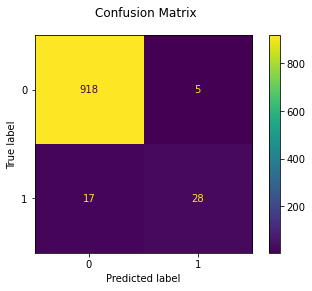

In [24]:
disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test, predicted)
disp.figure_.suptitle("Confusion Matrix")
print(f"Confusion matrix:\n{disp.confusion_matrix}")

plt.show()

In [25]:
import joblib
filename = 'SVC_model.pkl'
joblib.dump(clf, filename)

['SVC_model.pkl']

In [26]:
loaded_model = joblib.load(filename)
result = loaded_model.score(X_test, y_test)
print(result)

0.9772727272727273


In [60]:
#poniendo a prueba el modelo
def predecir_posicion_placa(imagen):
    predicted_final = clf.predict([np.reshape(imagen,(1,-1))[0]])
    return predicted_final

def generar_dict_subimagenes(imagen):
    dict_sub_imagenes={}
    for i in range(np.shape(array_centros)[0]):
        dict_sub_imagenes[i]=generar_sub_image(imagen,array_centros[i],W_fijo=60,H_fijo=112)
    return dict_sub_imagenes

def generar_predicciones_imagen(dict_sub_imagenes):
    dict_predicciones_imagen={}
    for i in range(np.shape(array_centros)[0]):
        dict_predicciones_imagen[i]=predecir_posicion_placa(dict_sub_imagenes[i])
    return dict_predicciones_imagen

def funcion_hallar_placas_imagen(imagen):
    dict_sub_imagenes_func=generar_dict_subimagenes(imagen)
    dict_predicciones_imagen_func=generar_predicciones_imagen(dict_sub_imagenes_func)
    array_placas_halladas=[]
    for i in dict_predicciones_imagen_func.keys():
        if dict_predicciones_imagen_func[i] == [1]:
            array_placas_halladas.append(i)
    return array_placas_halladas

def mostrar_resultados_de_pruebas_modelo(path):
    array_placas_halladas_final=funcion_hallar_placas_imagen(path)
    dict_sub_imagenes_total=generar_dict_subimagenes(path)
    m=1
    for i in array_placas_halladas_final:
        plt.subplot(4,3,m)
        plt.imshow(dict_sub_imagenes_total[i],cmap='gray')
        print(np.shape(dict_sub_imagenes_total[i]))
        m+=1
    return plt.show(),plt.imshow(cv2.imread(path),cmap='gray'),

(60, 112)
(60, 112)
(60, 112)
(60, 112)
(60, 112)
(60, 112)


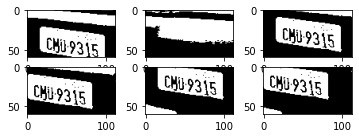

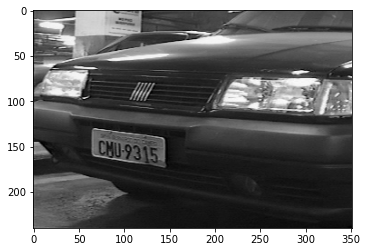

In [85]:
prueba_resultado=mostrar_resultados_de_pruebas_modelo('./placas-2/orig_0062.png')

In [33]:
# Create and fit a nearest-neighbor classifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
# classifier "out of the box", no parameters
knn = KNeighborsClassifier()
knn.fit(X_train, y_train) 

KNeighborsClassifier()

In [35]:
test_data_predicted = knn.predict(X_test)
print(accuracy_score(test_data_predicted, y_test))

0.9700413223140496


In [38]:
from sklearn.metrics import confusion_matrix 
cm = confusion_matrix(test_data_predicted, y_test)
print(cm) 

[[917  23]
 [  6  22]]


In [59]:
#poniendo a prueba el modelo
def predecir_posicion_placa_1(imagen):
    predicted_final = knn.predict([np.reshape(imagen,(1,-1))[0]])
    return predicted_final

def generar_dict_subimagenes_1(imagen):
    dict_sub_imagenes={}
    for i in range(np.shape(array_centros)[0]):
        dict_sub_imagenes[i]=generar_sub_image(imagen,array_centros[i],W_fijo=60,H_fijo=112)
    return dict_sub_imagenes

def generar_predicciones_imagen_1(dict_sub_imagenes):
    dict_predicciones_imagen={}
    for i in range(np.shape(array_centros)[0]):
        dict_predicciones_imagen[i]=predecir_posicion_placa_1(dict_sub_imagenes[i])
    return dict_predicciones_imagen

def funcion_hallar_placas_imagen_1(imagen):
    dict_sub_imagenes_func=generar_dict_subimagenes_1(imagen)
    dict_predicciones_imagen_func=generar_predicciones_imagen_1(dict_sub_imagenes_func)
    array_placas_halladas=[]
    for i in dict_predicciones_imagen_func.keys():
        if dict_predicciones_imagen_func[i] == [1]:
            array_placas_halladas.append(i)
    return array_placas_halladas

def mostrar_resultados_de_pruebas_modelo_1(path):
    array_placas_halladas_final=funcion_hallar_placas_imagen_1(path)
    dict_sub_imagenes_total=generar_dict_subimagenes_1(path)
    m=1
    for i in array_placas_halladas_final:
        plt.subplot(4,3,m)
        plt.imshow(dict_sub_imagenes_total[i],cmap='gray')
        np.shape(dict_sub_imagenes_total[i])
        m+=1
    return plt.show(),plt.imshow(cv2.imread(path),cmap='gray')

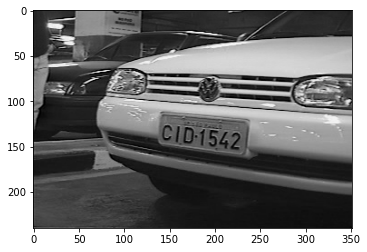

In [92]:
prueba_resultado=mostrar_resultados_de_pruebas_modelo_1('./placas-2/orig_0013.png')